In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

#from task_1a_1b import solve_op_scheme, solve_tp_scheme

#_ = %run -i task_1a_1b.ipynb

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4


In [2]:
#Scenario Data
with open('Data/ALL_scenarios.json') as f:
    all_scenarios = json.load(f)

all_scenarios.keys()

OMEGA = 250 # number of scenarios to sample
PI = 1 / OMEGA # probability of each sampled scenario - assumed to be equal

S = len(all_scenarios.keys()) - 1 # number of total scenarios
T = 24 # number of hours

WIND_CAPACITY = 200 #MWh

import random
random.seed(123)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(S), 250)

print(in_sample_scenarios)

scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(len(in_sample_scenarios)):
    scenarios[str(i)] = all_scenarios[str(in_sample_scenarios[i])]
    scenarios[str(i)]['Original Index'] = in_sample_scenarios[i]
    
print('Number of extracted scenarios:', len(scenarios))


alpha = 0.90  # Confidence level


[107, 548, 178, 1574, 834, 545, 220, 1717, 1845, 1791, 78, 776, 1098, 1151, 680, 697, 1745, 106, 326, 276, 690, 1148, 683, 1437, 502, 335, 3, 1855, 893, 1584, 179, 1799, 1223, 773, 143, 13, 646, 1499, 918, 208, 1854, 89, 189, 1366, 291, 258, 1618, 1856, 43, 597, 1866, 881, 1174, 976, 543, 961, 1715, 75, 624, 703, 1068, 1641, 989, 423, 1681, 1247, 1308, 1079, 1156, 1657, 1967, 645, 25, 815, 1828, 1575, 1323, 1050, 889, 1402, 1102, 1307, 1631, 1365, 1221, 1822, 1707, 995, 1066, 1369, 859, 767, 1044, 65, 1735, 1544, 1321, 371, 1486, 1679, 169, 1871, 997, 1347, 536, 348, 685, 1135, 801, 1810, 150, 1480, 935, 793, 1173, 1594, 688, 33, 387, 1200, 180, 1703, 1286, 744, 26, 1835, 720, 469, 830, 1089, 1026, 1482, 1687, 1861, 122, 589, 1013, 1974, 1565, 1290, 1475, 477, 1114, 990, 363, 314, 910, 775, 1539, 944, 90, 20, 275, 934, 395, 525, 1636, 556, 1955, 1298, 860, 0, 222, 1264, 128, 1045, 727, 1448, 181, 887, 1838, 17, 1629, 1097, 1119, 1421, 1300, 827, 59, 660, 537, 1957, 967, 67, 1537, 1150,

In [8]:
def cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values):
    results_per_beta = {}
    p_DA_values_per_beta = {}

    for beta in beta_values:
        direction = gb.GRB.MAXIMIZE  # Min / Max

        m = gb.Model()  # Create a Gurobi model
        m.setParam('OutputFlag', 0)

        #============= Variables =============
        p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA")  # day-ahead power bid
        delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta")  # decision variable for the power imbalance - can be negative
        price_coeff = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="K")  # price coefficient for the imbalance price wrt. the day-ahead price
        #threshold = m.addVars(OMEGA, lb=-gb.GRB.INFINITY, ub=0, name="Threshold")  # threshold variables for each scenario

        #============= Objective function =============
        # Set objective function - note that the day-ahead price is factored out of the sum
        expected_profit = (1-beta)* gb.quicksum(PI * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t, w] * delta[t, w]) for t in range(T) for w in range(OMEGA))
             
        profits = {}
        for w in range(OMEGA):
            for t in range(T):
                profits = [scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w])]
                #profits[(w, t)] = profit_expr
        
        # Sort profits in ascending order
        sorted_profits = np.sort(profits)

        # Calculate CVaR
        VaR_index = int(np.ceil(alpha * len(sorted_profits)))
        VaR_value = sorted_profits[VaR_index - 1]
        cvar = (1 / ((1 - alpha) * len(sorted_profits))) * np.sum(sorted_profits[:VaR_index])

        # var_sum = gb.quicksum(scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t, w] * delta[t, w]) for t in range(T) for w in range(OMEGA))
        # cvar = (1 / (1 - alpha)) * var_sum
        obj = expected_profit + beta * cvar
        m.setObjective(obj, direction)

        #============= Day-ahead power bid limits ============
        m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

        #============= Power imbalance definition (realized - bid) ===============
        m.addConstrs(delta[t, w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))

        #============= Price coefficient definition ===============
        m.addConstrs(price_coeff[t, w] == 1.2 * scenarios[str(w)]['System Balance State'][t] + 0.9 * (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

        #===========CVAR constraints===============
        m.addConstrs((-gb.quicksum(scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t, w] * delta[t, w]) for t in range(T) for w in range(OMEGA)) 
                    + VaR_value <= 0 for w in range(OMEGA)), name="RiskThreshold")

        #============= Display and run model =============
        m.update()
        m.optimize()

        #============= Results ============
        if m.status == gb.GRB.OPTIMAL:
            # Initialization of results
            results = {}
            for scenario in range(OMEGA):
                df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Imbalance [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State', 'Balancing Price Coefficient'])

                for t in range(T):
                    df.loc[t] = [t,
                                 scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t],
                                 scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x,
                                 delta[t, scenario].x, scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x,
                                 price_coeff[t, scenario].x * scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * delta[t, scenario].x,
                                 scenarios[str(scenario)]['System Balance State'][t], price_coeff[t, scenario].x]
                df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

                df['Hour'] = df['Hour'].astype(int)
                df['System State'] = df['System State'].astype(int)
                df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
                df.set_index('Hour', inplace=True)
                results[scenario] = df.copy(deep=True)
            
            cvar_value = beta*cvar.getValue()#(1 / (1 - alpha)) * (var_sum.getValue())
            adjusted_expected_profit = m.objVal - beta * cvar_value
            p_DA_values = [p_DA[t].x for t in range(T)]
            

            results['Adjusted Expected Profit'] = adjusted_expected_profit
            results['CVaR'] = cvar_value
            print('-----------------------------------------------')
            print('Results for beta=%.2f' % beta)
            print('Objective value (expected profit): %.2f EUR' % m.objVal)
            print('-----------------------------------------------')
            print('Day-ahead bids:')
            average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)
           
            summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State', 'Average Price Coefficient'])
            for t in range(T):
                summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]),
                                  np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                  np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                  np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)]),
                                  np.mean([price_coeff[t, w].x for w in range(OMEGA)])]

            summary['Hour'] = summary['Hour'].astype(int)
            summary.set_index('Hour', inplace=True)

            results['Summary'] = summary.copy(deep=True)

            for t in range(T):
                print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

            print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
            print('-----------------------------------------------')

            # Save results for this beta
            p_DA_values_per_beta[beta] = p_DA_values
            results_per_beta[beta] = results

        else:
            print("Optimization for beta=%.2f was not successful." % beta)

    return results_per_beta,p_DA_values_per_beta

beta_values = np.linspace(0, 1, 10) 

#results = solve_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values)


-----------------------------------------------
Results for beta=0.00
Objective value (expected profit): 169945.65 EUR
-----------------------------------------------
Day-ahead bids:
Hour 0 | Bid: 0.00 MW | Average Profit: 6088.45 EUR
Hour 1 | Bid: 0.00 MW | Average Profit: 6201.17 EUR
Hour 2 | Bid: 0.00 MW | Average Profit: 5634.33 EUR
Hour 3 | Bid: 0.00 MW | Average Profit: 5337.31 EUR
Hour 4 | Bid: 0.00 MW | Average Profit: 4900.24 EUR
Hour 5 | Bid: 0.00 MW | Average Profit: 5310.14 EUR
Hour 6 | Bid: 200.00 MW | Average Profit: 6318.35 EUR
Hour 7 | Bid: 0.00 MW | Average Profit: 6812.61 EUR
Hour 8 | Bid: 200.00 MW | Average Profit: 7829.89 EUR
Hour 9 | Bid: 200.00 MW | Average Profit: 7963.48 EUR
Hour 10 | Bid: 0.00 MW | Average Profit: 7897.94 EUR
Hour 11 | Bid: 0.00 MW | Average Profit: 7727.32 EUR
Hour 12 | Bid: 0.00 MW | Average Profit: 7582.19 EUR
Hour 13 | Bid: 0.00 MW | Average Profit: 8043.39 EUR
Hour 14 | Bid: 200.00 MW | Average Profit: 7558.93 EUR
Hour 15 | Bid: 0.00 MW |

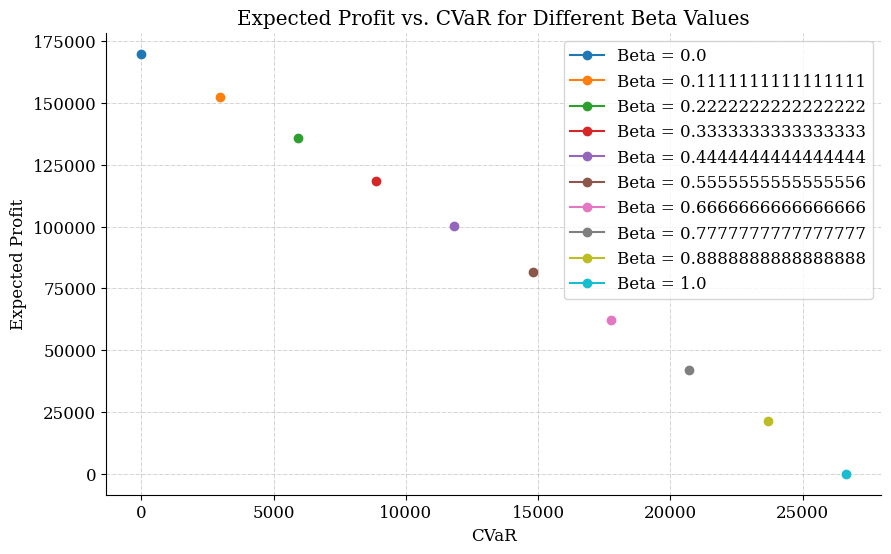

In [9]:
results_per_beta,p_DA_values_per_beta = cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values)

betas = list(results_per_beta.keys())

plt.figure(figsize=(10, 6))
for beta in betas:
    expected_values = results_per_beta[beta]['Adjusted Expected Profit']
    cvars = results_per_beta[beta]['CVaR']
    plt.plot(cvars, expected_values, marker='o', linestyle='-', label=f'Beta = {beta}')

plt.title('Expected Profit vs. CVaR for Different Beta Values')
plt.xlabel('CVaR')
plt.ylabel('Expected Profit')
plt.grid(True)
plt.legend()
plt.show()



In [10]:
for beta in betas:
    expected_values = results_per_beta[beta]['Adjusted Expected Profit']
    cvars = results_per_beta[beta]['CVaR']
    print(cvars)

0.0
2958.782969766489
5917.565939533288
8876.348909299762
11835.13187906657
14793.914848833198
17752.697818599845
20711.48078836646
23670.263758133126
26629.04672788523


In [ ]:
# beta_values = np.linspace(0, 1, 10)
# alpha = 0.90  # Confidence level

# def calculate_CVaR(scenarios, p_DA, delta, w, T,alpha):
#     # Calculate profits for all scenarios
#     profits = [scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t].x + delta[t,w].x) for t in range(T)]

#     # Sort profits in ascending order
#     sorted_profits = np.sort(profits)

#     # Calculate CVaR
#     VaR_index = int(np.ceil(alpha * len(sorted_profits)))
#     VaR_value = sorted_profits[VaR_index - 1]
#     CVaR_value = (1 / ((1 - alpha) * len(sorted_profits))) * np.sum(sorted_profits[:VaR_index])

#     return CVaR_value

In [17]:
def cvr_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values):
    results_per_beta = {}
    p_DA_values_per_beta = {}

    for beta in beta_values:
        print(f"Solving for beta = {beta}...")
        direction = gb.GRB.MAXIMIZE  # Min / Max

        m = gb.Model()  # Create a Gurobi model
        m.setParam('OutputFlag', 0)

        #============= Variables =============
        p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA")  # day-ahead power bid
        delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta")  # decision variable for the power imbalance - can be negative
        delta_up = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_up")  # surplus
        delta_down = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_down")  # deficit
        imbalance_revenue = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="I")  # imbalance revenue - can be negative
        y = m.addVars(T, OMEGA, vtype=gb.GRB.BINARY, name="y")  # binary variables
        z = m.addVars(4, T, OMEGA, vtype=gb.GRB.BINARY, name="z")  # binary variables for conditional statements

        #============= Objective function =============
        # Set objective function
        expected_profit = (1-beta)*gb.quicksum(PI * (scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]) for t in range(T) for w in range(OMEGA))
        
        profits = {}
        for w in range(OMEGA):
            for t in range(T):
                profits = [scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]]
                #profits[(w, t)] = profit_expr
        
        # Sort profits in ascending order
        sorted_profits = np.sort(profits)

        # Calculate CVaR
        VaR_index = int(np.ceil(alpha * len(sorted_profits)))
        VaR_value = sorted_profits[VaR_index - 1]
        cvar = (1 / ((1 - alpha) * len(sorted_profits))) * np.sum(sorted_profits[:VaR_index])

        # var_sum = gb.quicksum(scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + imbalance_revenue[t, w]) for t in range(T) for w in range(OMEGA))
        # cvar = (1 / (1 - alpha)) * var_sum
        obj = expected_profit + beta * cvar

        m.setObjective(obj, direction)

        #============= Day-ahead power bid limits ============
        m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

        #============= Power imbalance definitions ===============
        m.addConstrs(delta[t, w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(delta[t, w] == delta_up[t, w] - delta_down[t, w] for t in range(T) for w in range(OMEGA))

        M = 1e6  # big-M constant
        m.addConstrs(delta_up[t, w] <= M * (1 - y[t, w]) for t in range(T) for w in range(OMEGA))
        m.addConstrs(delta_down[t, w] <= M * y[t, w] for t in range(T) for w in range(OMEGA))

        #============= Linearized conditional statements ===============
        m.addConstrs(z[0, t, w] <= y[t, w] + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[1, t, w] <= y[t, w] + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[2, t, w] <= (1 - y[t, w]) + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[3, t, w] <= (1 - y[t, w]) + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

        m.addConstrs(imbalance_revenue[t, w] <= 0.9 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t, w] + M * z[0, t, w] for t in range(T) for w in range(OMEGA))
        m.addConstrs(imbalance_revenue[t, w] <= 1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t, w] + M * z[1, t, w] for t in range(T) for w in range(OMEGA))
        m.addConstrs(imbalance_revenue[t, w] <= -1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t, w] + M * z[2, t, w] for t in range(T) for w in range(OMEGA))
        m.addConstrs(imbalance_revenue[t, w] <= -1.2 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t, w] + M * z[3, t, w] for t in range(T) for w in range(OMEGA))

        #===========CVAR constraints===============
        m.addConstrs(-gb.quicksum((scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]) for t in range(T) for w in range(OMEGA))+ VaR_value <= 0 for w in range(OMEGA))

        m.update()
        m.optimize()

        #============= Results =============
        results = {}
        if m.status == gb.GRB.OPTIMAL:
            for scenario in range(OMEGA):
                df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Delta [MW]', 'Delta UP [MW]', 'Delta DOWN [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State'])

                for t in range(T):
                    df.loc[t] = [t,
                                 scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t],
                                 scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x,
                                 delta[t, scenario].x,
                                 delta_up[t, scenario].x,
                                 delta_down[t, scenario].x,
                                 scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x,
                                 imbalance_revenue[t, scenario].x,
                                 scenarios[str(scenario)]['System Balance State'][t]]
                df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

                df['Hour'] = df['Hour'].astype(int)
                df['System State'] = df['System State'].astype(int)
                df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
                df.set_index('Hour', inplace=True)
                results[scenario] = df.copy(deep=True)

            p_DA_values = [p_DA[t].x for t in range(T)]
            cvar_value = beta*cvar.getValue()
            adjusted_expected_profit = m.objVal - beta * cvar_value
            

            results['Adjusted Expected Profit'] = adjusted_expected_profit
            results['CVaR'] = cvar_value

            print('-----------------------------------------------')
            print(f'Objective value (expected profit + {beta} * CVaR): %.2f EUR' % m.objVal)
            print('-----------------------------------------------')
            print('Day-ahead bids:')
            average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

            summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State'])
            for t in range(T):
                summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]),
                                  np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                  np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                  np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)])]

            summary['Hour'] = summary['Hour'].astype(int)
            summary.set_index('Hour', inplace=True)

            results['Summary'] = summary.copy(deep=True)

            for t in range(T):
                print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

            print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
            print('-----------------------------------------------')
            # Save results for this beta
            results_per_beta[beta] = results
            p_DA_values_per_beta[beta] = p_DA_values

        else:
            print("Optimization for beta=%.2f was not successful." % beta)

    return results_per_beta,p_DA_values_per_beta

beta_values = np.linspace(0, 1, 10) 

#results = solve_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values)


Solving for beta = 0.0...
-----------------------------------------------
Objective value (expected profit + 0.0 * CVaR): 152848.34 EUR
-----------------------------------------------
Day-ahead bids:
Hour 0 | Bid: 39.12 MW | Average Profit: 5466.27 EUR
Hour 1 | Bid: 17.36 MW | Average Profit: 5337.92 EUR
Hour 2 | Bid: 25.52 MW | Average Profit: 5055.43 EUR
Hour 3 | Bid: 38.26 MW | Average Profit: 4784.52 EUR
Hour 4 | Bid: 59.65 MW | Average Profit: 4654.59 EUR
Hour 5 | Bid: 48.03 MW | Average Profit: 4963.35 EUR
Hour 6 | Bid: 110.63 MW | Average Profit: 5659.32 EUR
Hour 7 | Bid: 44.49 MW | Average Profit: 6365.12 EUR
Hour 8 | Bid: 82.47 MW | Average Profit: 7199.76 EUR
Hour 9 | Bid: 91.65 MW | Average Profit: 7138.68 EUR
Hour 10 | Bid: 30.65 MW | Average Profit: 7044.24 EUR
Hour 11 | Bid: 30.64 MW | Average Profit: 6873.71 EUR
Hour 12 | Bid: 30.53 MW | Average Profit: 6775.12 EUR
Hour 13 | Bid: 3.57 MW | Average Profit: 6899.64 EUR
Hour 14 | Bid: 84.25 MW | Average Profit: 6832.81 EUR


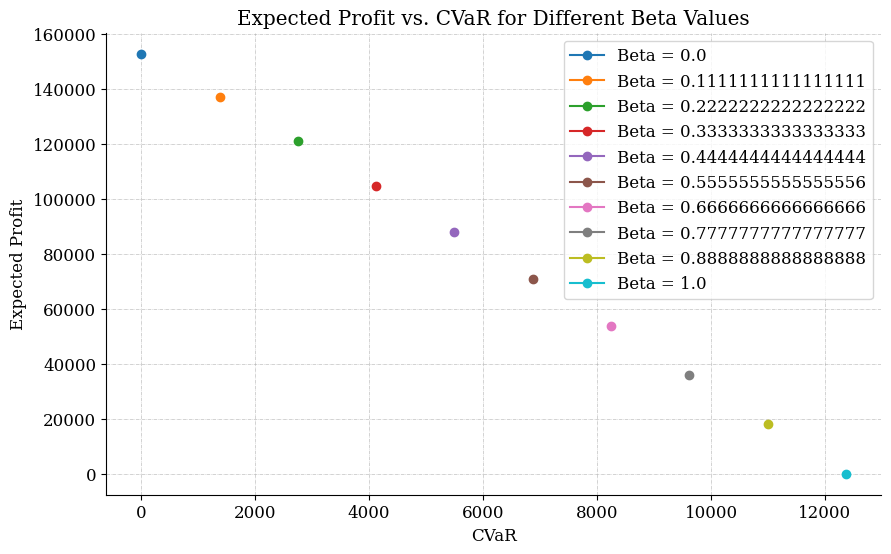

In [18]:

results_per_beta, p_DA_values_per_beta = cvr_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values)

betas = list(results_per_beta.keys())

plt.figure(figsize=(10, 6))
for beta in betas:
    expected_values = results_per_beta[beta]['Adjusted Expected Profit']
    cvars = results_per_beta[beta]['CVaR']
    plt.plot(cvars, expected_values, marker='o', linestyle='-', label=f'Beta = {beta}')

plt.title('Expected Profit vs. CVaR for Different Beta Values')
plt.xlabel('CVaR')
plt.ylabel('Expected Profit')
plt.grid(True)
plt.legend()
plt.show()
